# Cisco - Ariel University API Security Detection Challenge 2023
## Baseline code


### Imports and global settings

In [1]:
# Imports, settings and first dataset view
import pandas as pd
import seaborn as sns
import numpy as np
import json

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

# Global setting here you choose the dataset number and classification type for the model
dataset_number = 3 # Options are [1, 2, 3, 4]
test_type = 'label' # Options are ['label', 'attack_type']

# Read the json and read it to a pandas dataframe object, you can change these settings
with open(f'./dataset_{str(dataset_number)}_train.json') as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

# Shoe the first five lines of the dataframe to see if everything was read accordingly 
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,request.Attack_Tag,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Content-Length,response.headers.Location,request.headers.Cookie,response.headers.Set-Cookie
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=yGkqVSrlAG5SQ_fZmLWaNcmRrpqyDTqyfly6jHH51...,"Wed, 14 Dec 2022 23:59:27 GMT",GET,http://127.0.0.1:5000/greet/%7B%7Bget_flashed_...,,RCE,200 OK,text/html; charset=utf-8,48,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=CBhNqYCEwU1hN4CAD575di_4AcXDmw9CJAmtkmnri...,"Thu, 15 Dec 2022 00:36:21 GMT",GET,http://127.0.0.1:5000/about/greet?id=8730419.2...,,NaN,200 OK,text/html; charset=utf-8,93,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN
2,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=ZQg8nVqE2_D3CUsmSgDblTxzOkazD7RURCvUUcty_...,"Thu, 15 Dec 2022 00:47:40 GMT",GET,http://127.0.0.1:5000/static/download_txt/Inez...,,NaN,200 OK,application/json,88,200,"{""error"": ""File Inez.txtfilename=0MGnu5_DtpSPy...",NaN,NaN,NaN,NaN
3,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=3bV7UJGya8WbsvLb5oZMQfCX_kAxzzmCNHYnBZ6gd...,"Thu, 15 Dec 2022 00:45:52 GMT",GET,http://127.0.0.1:5000/categories/check/all?res...,,NaN,200 OK,application/json,871,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",NaN,NaN,NaN,NaN
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=GYA_AaxVnjLo7_TMm5qDgaJwuKEWzzJ3SU3UlNLqY...,"Thu, 15 Dec 2022 00:48:06 GMT",GET,http://127.0.0.1:5000/orders/get/id/4581?id=62...,,NaN,404 NOT FOUND,application/json,31,404,"{""error"": ""Order ID not found""}",NaN,NaN,NaN,NaN


### Basic dataset label arrangements

In [2]:
# Fill the black attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

# This function will be used in the lambda below to iterate over the label columns 
# You can use this snippet to run your own lambda on any data with the apply() method
def categorize(row):  
    if row['request.Attack_Tag'] == 'Benign':
        return 'Benign'
    return 'Malware'
#add new feature
def addfeature_url(df):
    url=[]
    for i in df["request.url"]:
        if "SELECT%20" in i or "select%20" in i:
            url.append("SQL")
        elif "OR%20" in i or "or%20" in i:
            url.append("SQL")
        elif "/../" in i:
            url.append("Directory Traversal")
        elif ".__" in i:
            url.append("RCE")
        elif "import" in i:
            url.append("RCE")
        elif "script" in i:
            url.append("RCE")
        elif "%20" in i:
            url.append("Log Forging")
        elif "forum" in i:
            url.append("XSS")
        elif "cookielogin" in i:
            url.append("Cookie Injection")
        else:
            url.append("None")
    df['url'] = url
    
#add new feature
def addfeature_Cookie(df):
    mal_co=[]
    for i in df["request.headers.Set-Cookie"]:
        if(type(i)==float):
            mal_co.append("None")
        elif "${" in i:
            mal_co.append("mal")
        else:
            mal_co.append("None")
    df['mal_co'] = mal_co
    
def addfeature_Sec_Fetch_Site(df):    
    mal_Sec=[]
    for i in df["request.headers.Sec-Fetch-Site"]:
        if(type(i)==float):
            mal_Sec.append("None")
        elif "${" in i:
            mal_Sec.append("mal")
        else:
            mal_Sec.append("None")
    df['mal_set'] = mal_Sec
    
def addfeature_Encoding(df):    
    mal_Encoding=[]
    for i in df["request.headers.Accept-Encoding"]:
        if(type(i)==float):
            mal_Encoding.append("None")
        elif "${" in i:
            mal_Encoding.append("mal")
        else:
            mal_Encoding.append("None")        
    df['mal_Encoding'] = mal_Encoding
    
def addfeature_Sec_Fetch_Mode(df): 
    Fetch_Mode=[]
    for i in df["request.headers.Sec-Fetch-Mode"]:
        if(type(i)==float):
            Fetch_Mode.append("None")
        elif "${" in i:
            Fetch_Mode.append("mal")
        else:
            Fetch_Mode.append("None")
    df['Fetch_Mode'] = Fetch_Mode
    
def addfeature_Sec_Fetch_Dest(df): 
    Fetch_Dest=[]
    for i in df["request.headers.Sec-Fetch-Dest"]:
        if(type(i)==float):
            Fetch_Dest.append("None")
        elif "${" in i:
            Fetch_Dest.append("mal")
        else:
            Fetch_Dest.append("None")
    df['Fetch_Dest'] = Fetch_Dest


# After finishing the arrangements we delete the irrelevant column
df['label'] = df.apply(lambda row: categorize(row), axis=1)
addfeature_url(df)
addfeature_Cookie(df)
addfeature_Sec_Fetch_Site(df)
addfeature_Encoding(df)
addfeature_Sec_Fetch_Mode(df)
addfeature_Sec_Fetch_Dest(df)
df.drop('request.Attack_Tag', axis=1, inplace=True)
df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Content-Length,response.headers.Location,request.headers.Cookie,response.headers.Set-Cookie,attack_type,label,url,mal_co,mal_set,mal_Encoding,Fetch_Mode,Fetch_Dest
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=yGkqVSrlAG5SQ_fZmLWaNcmRrpqyDTqyfly6jHH51...,"Wed, 14 Dec 2022 23:59:27 GMT",GET,http://127.0.0.1:5000/greet/%7B%7Bget_flashed_...,,200 OK,text/html; charset=utf-8,48,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN,RCE,Malware,RCE,None,None,None,None,None
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=CBhNqYCEwU1hN4CAD575di_4AcXDmw9CJAmtkmnri...,"Thu, 15 Dec 2022 00:36:21 GMT",GET,http://127.0.0.1:5000/about/greet?id=8730419.2...,,200 OK,text/html; charset=utf-8,93,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN,Benign,Benign,None,None,None,None,None,None
2,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=ZQg8nVqE2_D3CUsmSgDblTxzOkazD7RURCvUUcty_...,"Thu, 15 Dec 2022 00:47:40 GMT",GET,http://127.0.0.1:5000/static/download_txt/Inez...,,200 OK,application/json,88,200,"{""error"": ""File Inez.txtfilename=0MGnu5_DtpSPy...",NaN,NaN,NaN,NaN,Benign,Benign,None,None,None,None,None,None
3,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=3bV7UJGya8WbsvLb5oZMQfCX_kAxzzmCNHYnBZ6gd...,"Thu, 15 Dec 2022 00:45:52 GMT",GET,http://127.0.0.1:5000/categories/check/all?res...,,200 OK,application/json,871,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",NaN,NaN,NaN,NaN,Benign,Benign,None,None,None,None,None,None
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=GYA_AaxVnjLo7_TMm5qDgaJwuKEWzzJ3SU3UlNLqY...,"Thu, 15 Dec 2022 00:48:06 GMT",GET,http://127.0.0.1:5000/orders/get/id/4581?id=62...,,404 NOT FOUND,application/json,31,404,"{""error"": ""Order ID not found""}",NaN,NaN,NaN,NaN,Benign,Benign,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144495,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) G...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=CUsow_eOa54yp9oNsd1BhZF2lKtgt-PGMG7iBnLba...,"Thu, 15 Dec 2022 00:49:47 GMT",GET,http://127.0.0.1:5000/?res_id=kc66M-9P2z2nOc6C...,,200 OK,text/html; charset=utf-8,34,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN,Benign,Benign,None,None,None,None,None,None
144496,127.0.0.1:5000,python-requests/2.28.1,"gzip, deflate",*/*,keep-alive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GET,http://127.0.0.1:5000/bookstore,,200 OK,application/json,41,200,"{""message"": ""Welcome to the Book Store!""}",NaN,NaN,NaN,NaN,Benign,Benign,None,None,None,None,None,None
144497,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; r...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=wo-zV78-fKpHPJjNrkXs_EyYZNCJ_VErr0hf4O8l1...,"Thu, 15 Dec 2022 00:47:04 GMT",GET,http://127.0.0.1:5000/greet/Manuel,,200 OK,text/html; charset=utf-8,22,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN,Benign,Benign,None,None,None,None,None,None
144498,127.0.0.1:5000,Mozilla/5.0 (X11; Ubun

In [3]:
# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
for column in df.columns[df.isna().any()].tolist():
    print(column)
    # df.drop(column, axis=1, inplace=True)
    df[column] = df[column].fillna('None')

    
# If you want to detect columns that may have only some NaN values use this:
# df.loc[:, df.isna().any()].tolist()

# df

request.headers.Accept-Language
request.headers.Sec-Fetch-Site
request.headers.Sec-Fetch-Mode
request.headers.Sec-Fetch-User
request.headers.Sec-Fetch-Dest
request.headers.Set-Cookie
request.headers.Date
request.headers.Content-Length
response.headers.Location
request.headers.Cookie
response.headers.Set-Cookie


In [4]:
# Setting features for further feature extraction by choosing columns
# Some will be "simply" encoded via label encoding and others with HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
# settings that you use for count vectorizer will go here 
SIMPLE_HEADERS = [
                'request.headers.Accept-Language',
                'response.status',
                'url',
                'mal_co',
                'mal_set',
                'mal_Encoding',
                'Fetch_Mode',
                'Fetch_Dest'
                ]

# On these headers we will run HashingVectorizer
COMPLEX_HEADERS = [ 
                    
                    'response.body',
                    'request.headers.Content-Length',
                    'request.headers.Cookie',
                    'response.headers.Set-Cookie'
                  ]

COLUMNS_TO_REMOVE = ['request.body',
                     'response.headers.Content-Type',
                     'request.headers.User-Agent',
                        'request.method',
                    'request.url',
                    'request.headers.Set-Cookie',
                    'request.headers.Accept-Encoding',
                    'request.headers.Sec-Fetch-Site',
                     'request.headers.Sec-Fetch-Mode',
                     'request.headers.Sec-Fetch-Dest',
                     'response.headers.Location',
                     'request.headers.Host',
                     'request.headers.Accept',
                     'request.headers.Sec-Fetch-User',
                     'request.headers.Connection',
                     'response.headers.Content-Length',
                     'request.headers.Date']

# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):
    #encode to 0 or 1
    le = LabelEncoder()
    h_vec = HashingVectorizer(n_features=4)
# just send in all your docs here 
# On these headers we will run a "simple" BOW
    # Run LabelEncoder on the chosen features
    for column in SIMPLE_HEADERS: 
        df[column] = le.fit_transform(df[column])
    # Run HashingVectorizer on the chosen features
    for column in COMPLEX_HEADERS: 
        newHVec = h_vec.fit_transform(df[column])
        df[column] = newHVec.todense()
    # Remove some columns that may be needed.. (Or not, you decide)
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
    return df

df = vectorize_df(df)

df



,request.headers.Accept-Language,response.status,response.status_code,response.body,request.headers.Content-Length,request.headers.Cookie,response.headers.Set-Cookie,attack_type,label,url,mal_co,mal_set,mal_Encoding,Fetch_Mode,Fetch_Dest
0,2,0,200,-1.000000,-1.0,-1.0,-1.0,RCE,Malware,4,0,0,0,0,0
1,3,0,200,-1.000000,-1.0,-1.0,-1.0,Benign,Benign,3,0,0,0,0,0
2,4,0,200,0.377964,-1.0,-1.0,-1.0,Benign,Benign,3,0,0,0,0,0
3,4,0,200,-0.255551,-1.0,-1.0,-1.0,Benign,Benign,3,0,0,0,0,0
4,1,5,404,0.000000,-1.0,-1.0,-1.0,Benign,Benign,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144495,1,0,200,-1.000000,-1.0,-1.0,-1.0,Benign,Benign,3,0,0,0,0,0
144496,0,0,200,0.000000,-1.0,-1.0,-1.0,Benign,Benign,3,0,0,0,0,0
144497,2,0,200,-1.000000,-1.0,-1.0,-1.0,Benign,Benign,3,0,0,0,0,0
144498,3,0,200,0.000000,-1.0,-1.0,-1.0,Benign,Benign,3,0,0,0,0,0


In [5]:
# Memory check (For large datasets sometimes the dataframe will exceed the computers resources)
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144500 entries, 0 to 144499
Data columns (total 15 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   request.headers.Accept-Language  144500 non-null  int32  
 1   response.status                  144500 non-null  int32  
 2   response.status_code             144500 non-null  int64  
 3   response.body                    144500 non-null  float64
 4   request.headers.Content-Length   144500 non-null  float64
 5   request.headers.Cookie           144500 non-null  float64
 6   response.headers.Set-Cookie      144500 non-null  float64
 7   attack_type                      144500 non-null  object 
 8   label                            144500 non-null  object 
 9   url                              144500 non-null  int32  
 10  mal_co                           144500 non-null  int32  
 11  mal_set                          144500 non-null  int32  
 12  ma

In [6]:
# Choose the right features
# In our example code we choose all the columns as our feature this can be the right or wrong way to approach the model, you choose.

features_list = df.columns.to_list()
features_list.remove('label')
features_list.remove('attack_type')
print(features_list)

# Recheck all datatype before training to see we don't have any objects in our features
# In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing
df.dtypes

['request.headers.Accept-Language', 'response.status', 'response.status_code', 'response.body', 'request.headers.Content-Length', 'request.headers.Cookie', 'response.headers.Set-Cookie', 'url', 'mal_co', 'mal_set', 'mal_Encoding', 'Fetch_Mode', 'Fetch_Dest']


request.headers.Accept-Language      int32
response.status                      int32
response.status_code                 int64
response.body                      float64
request.headers.Content-Length     float64
request.headers.Cookie             float64
response.headers.Set-Cookie        float64
attack_type                         object
label                               object
url                                  int32
mal_co                               int32
mal_set                              int32
mal_Encoding                         int32
Fetch_Mode                           int32
Fetch_Dest                           int32
dtype: object

## Train test split

In [7]:
# Data train and test split preparations. Here we will insert our feature list and label list.
# Afterwards the data will be trained and fitted on the amazing XGBoost model
# X_Train and y_Train will be used for training
# X_test and y_test.T will be used for over fitting checking and overall score testing

# We convert the feature list to a numpy array, this is required for the model fitting
X = df[features_list].to_numpy()

# This column is the desired prediction we will train our model on
y = np.stack(df[test_type])

# We split the dataset to train and test according to the required ration
# Do not change the test_size -> you can change anything else
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1765, random_state=42, stratify=y)

# We print the resulted datasets and count the difference 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)
counter

(118995, 13) (118995,)
(25505, 13) (25505,)


Counter({'Malware': 16080, 'Benign': 128420})

## Model choosing and fitting

In [8]:
from sklearn.neighbors import NearestCentroid
from sklearn import tree
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
# We choose our model of choice and set it's hyper parameters you can change anything
clf = RandomForestClassifier(n_estimators=40)
clf.fit(X_train, y_train)
print(sorted(Counter(y_train).items()))

[('Benign', 105753), ('Malware', 13242)]


## Result printout

              precision    recall  f1-score   support

      Benign    1.00000   1.00000   1.00000     22667
     Malware    1.00000   1.00000   1.00000      2838

    accuracy                        1.00000     25505
   macro avg    1.00000   1.00000   1.00000     25505
weighted avg    1.00000   1.00000   1.00000     25505



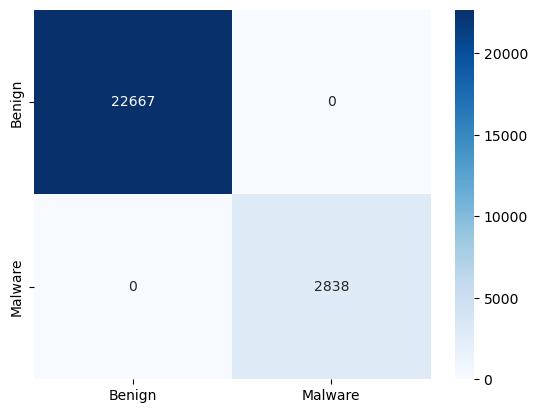

In [9]:
import statistics
# We print our results
predictions = clf.predict(X_test)
true_labels = y_test
cf_matrix = confusion_matrix(true_labels, predictions)
clf_report = classification_report(true_labels, predictions, digits=5)
heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(clf_report)

# Test

In [10]:
# Now it's your turn, use the model you have just created :)

# Read the valuation json, preprocess it and run your model 
with open(f'./dataset_{str(dataset_number)}_val.json') as file:
    raw_ds = json.load(file)
test_df = pd.json_normalize(raw_ds, max_level=2)
# This loop iterates over all of the column names which are all NaN
for column in test_df.columns[test_df.isna().any()].tolist():
    print(column)
    # df.drop(column, axis=1, inplace=True)
    test_df[column] = test_df[column].fillna('None')
addfeature_url(test_df)
addfeature_Cookie(test_df)
addfeature_Sec_Fetch_Site(test_df)
addfeature_Encoding(test_df)
addfeature_Sec_Fetch_Mode(test_df)
addfeature_Sec_Fetch_Dest(test_df)
# Preprocess the validation dataset, remember that here you don't have the labels
test_df = vectorize_df(test_df)

# Predict with your model
X = test_df[features_list].to_numpy()
#predictions = predictions_M(X,clf,treeMachine,neigh)
predictions = clf.predict(X)

request.headers.Accept-Language
request.headers.Sec-Fetch-Site
request.headers.Sec-Fetch-Mode
request.headers.Sec-Fetch-User
request.headers.Sec-Fetch-Dest
request.headers.Set-Cookie
request.headers.Date
request.headers.Cookie
request.headers.Content-Length
response.headers.Location
response.headers.Set-Cookie


# Save your predictions

In [11]:
# Save your preditions
enc = LabelEncoder()
np.savetxt(f'./dataset_{str(dataset_number)}_{test_type}_result.txt', enc.fit_transform(predictions), fmt='%2d')